# Projet numérique 2021

In [1]:
# Chargement des dépendances

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib notebook

In [2]:
#Résultats issus du projet numérique 2020
#Discrétisation

A=0
B=500
N=101 #Nombre de points de discrétisation
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta

#Paramètres du modèle

mu=-5
a = 50
sigma2 = 12

#Données

observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

#Indices des composantes correspondant aux observations et aux componsantes non observées

unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

#Fonction C

def Covexp(dist,rangeval,sigmaval):
    return sigmaval * np.exp(-dist/rangeval)

#Calcul de la matrice de distances

distmat=abs(np.subtract.outer(discretization,discretization))

#Calcul de la matrice de covariances et de ses blocs

Sigma=Covexp(distmat,a,sigma2)
SigmaObs = Sigma[observation_indexes,:][:,observation_indexes]
SigmaObsUnknown = Sigma[observation_indexes,:][:,unknown_indexes]
SigmaUnknown = Sigma[unknown_indexes,:][:,unknown_indexes]

#Calcul de l'espérance conditionnelle des composantes non observées

invSigma = np.linalg.inv(SigmaObs) 
Ec= mu+np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth-mu))

#Calcul de la matrice de covariance conditionnelle (complément de Schur de la matrice de covariance SigmaUnknown)

SigmaCond = SigmaUnknown - np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),SigmaObsUnknown))

#Décomposition de Cholesky

Cholesky = np.linalg.cholesky(SigmaCond)

#Fonction calculant la longueur du fond marin

def length(z,delta):
    return sum(np.sqrt(Delta**2+(z[1:N]-z[0:-1])**2))

## Valeurs positives

### Question 1

On reprend le code du projet précédent à partir de la partie simulation, où l'on implémente une boucle de rejet afin de ne garder que des valeurs négatives pour la profondeur.

<IPython.core.display.Javascript object>


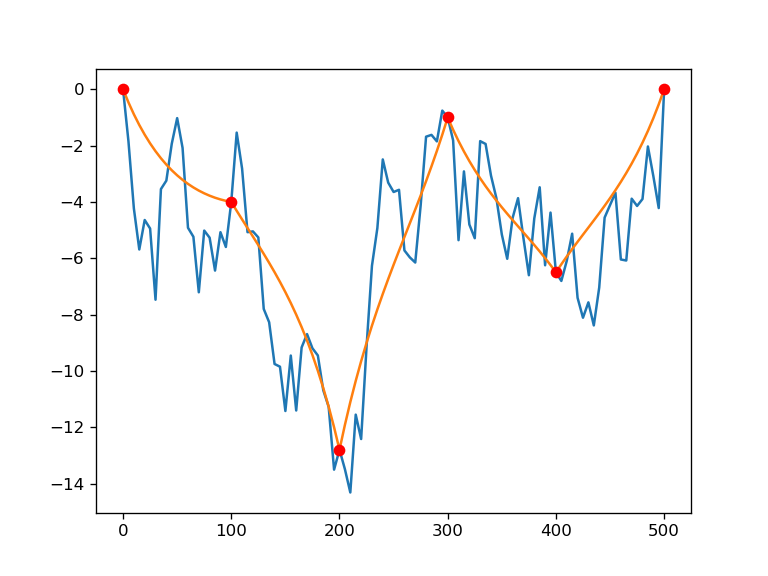

In [3]:
#Simulation de l'espérance conditionnelle des inconnues sachant les observations

x = np.random.normal(0,1,np.shape(unknown_indexes)[0])

simu = Ec + np.matmul(Cholesky,x)

for n in range(len(simu)):
    while simu[n]>0: #rejet et on resimule
        y = np.random.normal(0,1,np.shape(unknown_indexes)[0])
        simu[n] = Ec[n] + np.matmul(Cholesky,y)[n]

#Simulation

allval1 = np.zeros(N)
allval1[unknown_indexes]=Ec
allval1[observation_indexes]=depth

allval3 = np.zeros(N)
allval3[unknown_indexes]=simu
allval3[observation_indexes]=depth
plt.plot(discretization,allval3)
plt.plot(discretization,allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()

### Question 2

In [4]:
#On simule K fois la longueur du fond marin

K=100000

result = np.zeros(K)

for i in range(K):
    x=np.random.normal(0,1,np.shape(unknown_indexes)[0])
    allval3[unknown_indexes]=Ec + np.matmul(Cholesky,x)
    result[i]=length(allval3,Delta)

print("La longueur moyenne des simulations vaut", sum(result)/K)

La longueur moyenne des simulations vaut 522.4246818554924


In [5]:
#On calcule la longueur du fond marin de l'espérance conditionnelle des composantes non observées

print("La longueur de l'espérance conditionnelle vaut", length(allval1,Delta))

La longueur de l'espérance conditionnelle vaut 501.6468416918411


La longueur moyenne des simulations est pratiquement identique au cas sans la méthode de rejet.

<IPython.core.display.Javascript object>


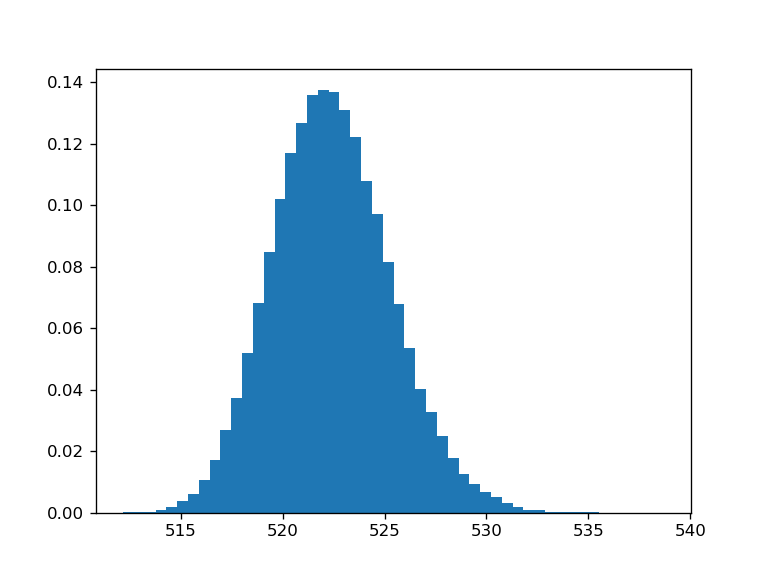

In [6]:
#Calcul de l'histogramme des longueurs du fond marin

indice_simu = 1+np.arange(K)

plt.hist(result,50,density=True)
plt.show()

L'histogramme garde la même forme qu'avant l'implémentation de la méthode de rejet, avec la même légère asymétrie.

In [7]:
#On reprend l'intervalle de confiance du projet précédent, 1ère méthode

Ln = sum(result)/K
sigman = np.std(result)
[Ln - sigman*1.96,Ln + sigman*1.96]

[516.755383727962, 528.0939799830228]

Ici encore rien n'est changé.

In [8]:
#Pour la probabilité de dépasser 525m

print(np.mean(result>525))

0.1835


On retrouve encore un résultat très proche du précédent.

In [9]:
#Estimation du taux de rejet de l'algorithme sur N itérations

N = 10000

rejets = 0 #nombre de simulations en plus divisé par le nombre de simulations totales

x = np.random.normal(0,1,np.shape(unknown_indexes)[0])

for n in range(N):
    simu = Ec + np.matmul(Cholesky,x)

for n in range(len(simu)):
    while simu[n]>0: #rejet et on resimule
        y = np.random.normal(0,1,np.shape(unknown_indexes)[0])
        simu[n] = Ec[n] + np.matmul(Cholesky,y)[n]
        rejets+=1

print("Le taux de rejet vaut",rejets/N)

Le taux de rejets vaut 0.0002


## Approche Bayésienne

Dans la première partie, on a considéré que l'ensemble des paramètres du modèle était parfaitement connu. Toutes choses égales par ailleurs, on va maintenant considérer que la moyenne $\mu$ est issue d'une estimation entâchée d'une incertitude. Plus précisément, on va modéliser cette incertitude en considérant que $\mu \sim \mathcal{N}(-5,4)$.

On va également décomposer le vecteur $\mathbf{Z}$ en $\mathbf{Z} = (\mathbf{Z}_{\text{OBS}},\mathbf{Z}_{\text{UNK}})$. On notera $C_{\text{OBS}}$ et $C_{\text{UNK}}$ les matrices de covariance respectives de $\mathbf{Z}_{\text{OBS}}$ et $\mathbf{Z}_{\text{UNK}}$ ainsi que $C_{\text{OBS},\text{UNK}}$ la matrice des covariances entre ces deux vecteurs.

### Question 3

Montrer que $\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}} \sim \mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$ avec
$$\widehat{\sigma}^2 = (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1},$$ 
où $\mathbf{1}$ est un vecteur de longueur 6 (soit la longueur du vecteur $\mathbf{Z}_{\text{OBS}}$) ne contenant que des 1 et 
$$\widehat{\mu} = \widehat{\sigma}^2 (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{z}_{\text{OBS}} - \frac{5}{4} )$$
Indication : écrire la densité jointe du vecteur $(\mathbf{Z}_{\text{OBS}},\mu)$, calculer $-2 \ln$ de cette densité puis identifier la forme quadratique faisant intervenir $\mu$.

Avec une formule de Bayes pour fonctions normales

### Question 4

On écrit les relations entre densités conditionnelles et de triplés, dans un cas en considérant la condition sur la variable Z seulement, dans le deuxième cas la condition porte sur le couple (Y,Z)

Par les relations entre densités, on a d'abord pour tous vecteurs $x,y,z$

$$f_{X,Y,Z}(x,y,z) = f_{X|Y=y,Z=z}(x)f_{Y,Z}(y,z)$$

Puis

$$f_{X,Y,Z}(x,y,z) = f_{X,Y|Z=z}(x,y)f_{Z}(z)$$

D'où on déduit

$$f_{X,Y|Z=z}(x,y) = \frac{f_{X,Y,Z}(x,y,z)}{f_{Z}(z)} = \frac{f_{X|Y=y,Z=z}(x)f_{Y,Z}(y,z)}{f_{Z}(z)}$$

Avec $$f_{Y|Z=z}(y) = \frac{f_{Y,Z}(y,z)}{f_{Z}(z)}$$

Finalement on a la relation cherchée

$$f_{X,Y|Z=z}(x,y) = f_{X|Y=y,Z=z}(x)f_{Y|Z=z}(y)$$

### Question 5

En déduire que la densité de $(\mathbf{Z}_{\text{UNK}},\mu) | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$ s'écrit comme le produit de $f_{\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ et de $f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ que l'on exprimera.

Indication : $f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ est identique à la densité $f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ utilisée dans la partie 1 avec $\mu = \mu^\star$

On utilise la proposition précédente avec $(x,y,z) = (z_{UNK},\mu^\star,z_{OBS}) $ et
$(X,Y,Z) = (Z_{UNK},\mu,Z_{OBS})$

Cela donne

$$f_{\mathbf{Z}_{\text{UNK}},\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(z_{UNK},\mu^\star) =
f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(z_{UNK})
f_{\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(\mu^\star)$$

En utilisant le fait que $f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}=f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$

On obtient que

$$f_{\mathbf{Z}_{\text{UNK}},\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(z_{UNK},\mu^\star) =
f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(z_{UNK})
f_{\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(\mu^\star)$$

## Simulation

### Question 6

On rappelle les expressions de $\widehat{\sigma}^2$ et de $\widehat{\mu}$ :
$$\widehat{\sigma}^2 = (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1},$$ 
$$\widehat{\mu} = \widehat{\sigma}^2 (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{z}_{\text{OBS}} - \frac{5}{4} )$$

In [23]:
#Calcul de muCh et SigmaCh (Ch pour chapeau)

SigmaCh = (np.linalg.inv(np.matmul(np.ones([1,6]),np.matmul(np.linalg.inv(SigmaObs),np.ones([6,1]))))[0])[0]

muCh = (SigmaCh * (np.matmul(np.ones([1,6]),np.matmul(np.linalg.inv(SigmaObs),np.transpose(depth))) - 5/4)[0])

print(SigmaCh,muCh)

2.4958554345773334 -6.968997842217846


### Question 7

Calculer la probabilité de $\{\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}} > 0\}$. Proposer et implémenter un algorithme de simulation de $\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}, \mu <0$.

In [25]:
#On appelle vaMuCond la variable aléatoire conditionnelle

K=100000

result = np.zeros(K)

for i in range(K):
    x = np.random.normal(muCh,SigmaCh)
    result[i]=x

print(np.mean(result>0))

0.00272


Ainsi pour simuler $\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}, \mu <0$ on utilise la méthode de rejet

### Question 8

Générer un couple $\mathbf{Z}_{\text{UNK}}, \mu| \mathbf{Z}_{\text{OBS}}, \mu <0$ et représenter le profil de profondeur obtenu. On prendra soin de ne générer que des valeurs négatives de $\mathbf{Z}_{\text{UNK}}$ en utilisant l'algorithme de la section précédente.

### Question 9

Générer 10000 profils de profondeur et calculer les longueurs de câble associées. Comparer la valeur moyenne de la longueur de câble, dont on visualisera la convergence, l'histogramme des longueurs de câble, l'intervalle de confiance obtenu par la méthode des quantiles, la probabilité de dépassement du seuil de 525 m avec les résultats obtenus précédemment. Commenter.

### Question 10

Qu'adviendrait-il selon vous si on rendait également aléatoires les autres paramètres du modèle $\sigma^2$ et $a$ ?

### Question 11

(facultatif) On suppose désormais que $\alpha = \frac1{\sigma^2} \sim \Gamma(a_1,a_2)$, où $\sigma^2$ correspond au paramètre qui intervient dans la fonction $C$. Donner l'expression de la densité de $\alpha | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$,  de $\mu | \alpha, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}},$ et de $\mathbf{Z}_{\text{UNK}} | \mu, \alpha, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$. Proposer un algorithme de simulation tenant compte de l'incertitude sur le paramètre $\alpha$ et analyser son impact sur les différentes quantités évaluées.

Indication : Pour identifier la densité de $\alpha | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$, exprimer d'abord la densité jointe de $(\alpha,\mu, \mathbf{Z}_{\text{OBS}})$ puis marginaliser pour obtenir la densité de $(\alpha,\mathbf{Z}_{\text{OBS}})$